In [1]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow import keras



In [2]:


# Set the paths to your train, test, and validation directories
train_dir = "final_dataset/train"
test_dir = "final_dataset/test"
val_dir = "final_dataset/validation"

# Define the image size and number of classes
image_size = (224, 224)
num_classes = 101

# Create data generators with data augmentation for the train set
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=0.4,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical"
)

# Create data generators for the test and validation sets (no data augmentation)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical",
    shuffle=False  # Do not shuffle test data for evaluation
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical"
)




Found 75750 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


In [7]:
# Load pre-trained EfficientNet B0 model with weights from ImageNet
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers[:-38]:  # Fine-tune the last 100 layers
    layer.trainable = True
for layer in base_model.layers[-38:]:
    layer.trainable = False

# Define the top layers for fine-tuning
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

model = keras.models.Model(inputs=base_model.input, outputs=output)



# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Adjust learning rate as needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [8]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 

In [11]:
# Define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    'efficient32-1_transfer_learning_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', patience=13, verbose=1, restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)


In [12]:
import time
start_time = time.time()

In [13]:
# Train the model
history = model.fit(
        train_generator,
        epochs=300,
        validation_data=val_generator,
        callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr]
)


Epoch 1/300


2023-11-23 05:27:08.035389: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500
2023-11-23 05:27:09.020887: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4735/4735 [==============================] - ETA: 0s - loss: 1.9362 - accuracy: 0.5231
Epoch 1: val_loss improved from inf to 1.15693, saving model to efficient32-1_transfer_learning_model.h5
4735/4735 [==============================] - 692s 144ms/step - loss: 1.9362 - accuracy: 0.5231 - val_loss: 1.1569 - val_accuracy: 0.6934 - lr: 1.0000e-04
Epoch 2/300
4735/4735 [==============================] - ETA: 0s - loss: 1.2408 - accuracy: 0.6734
Epoch 2: val_loss improved from 1.15693 to 0.96581, saving model to efficient32-1_transfer_learning_model.h5
4735/4735 [==============================] - 681s 144ms/step - loss: 1.2408 - accuracy: 0.6734 - val_loss: 0.9658 - val_accuracy: 0.7449 - lr: 1.0000e-04
Epoch 3/300
4735/4735 [==============================] - ETA: 0s - loss: 1.0565 - accuracy: 0.7170
Epoch 3: val_loss improved from 0.96581 to 0.89023, saving model to efficient32-1_transfer_learning_model.h5
4735/4735 [==============================] - 680s 144ms/step - loss: 1.0565 - accura

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3335/4735 [====================>.........] - ETA: 3:16 - loss: 0.4648 - accuracy: 0.8630

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4735/4735 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8962
Epoch 16: val_loss did not improve from 0.76871
4735/4735 [==============================] - 681s 144ms/step - loss: 0.3532 - accuracy: 0.8962 - val_loss: 0.7701 - val_accuracy: 0.8138 - lr: 1.0000e-05
Epoch 17/300
4735/4735 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.9040
Epoch 17: val_loss improved from 0.76871 to 0.76361, saving model to efficient32-1_transfer_learning_model.h5
4735/4735 [==============================] - 684s 144ms/step - loss: 0.3248 - accuracy: 0.9040 - val_loss: 0.7636 - val_accuracy: 0.8171 - lr: 1.0000e-05
Epoch 18/300
4735/4735 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.9079
Epoch 18: val_loss did not improve from 0.76361
4735/4735 [==============================] - 682s 144ms/step - loss: 0.3154 - accuracy: 0.9079 - val_loss: 0.7691 - val_accuracy: 0.8142 - lr: 1.0000e-05
Epoch 19/300
4735/4735 [=====================

In [14]:
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

Total training time: 20462.75 seconds


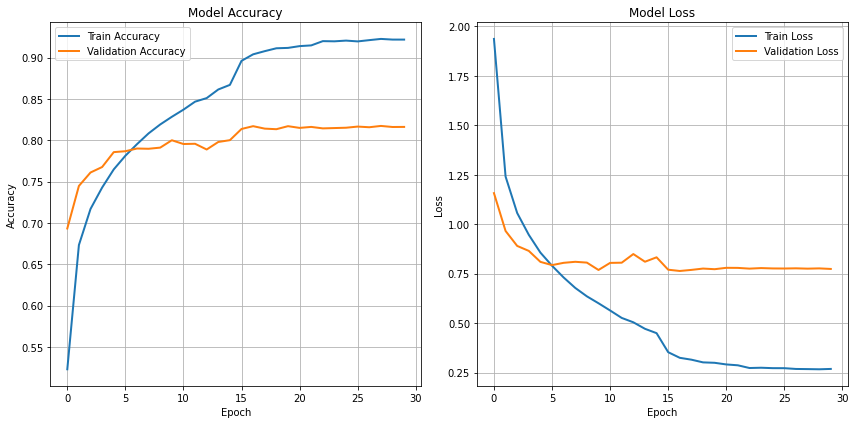

In [15]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [16]:
# Calculate metrics
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = [tf.argmax(pred).numpy() for pred in predictions]
y_true = test_generator.classes

947/947 [==============================] - 31s 31ms/step
